In [1]:
import pandas as pd
import cv2
import seaborn_image as isns
from IPython.display import Markdown as md
from os import listdir
from os.path import isfile, join
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import minkowski, euclidean
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

<Axes: >

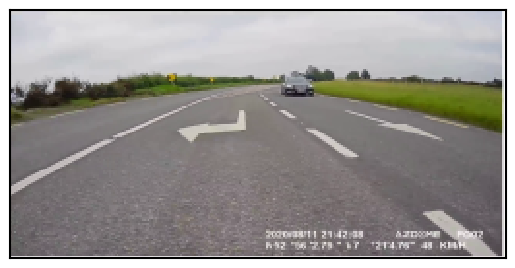

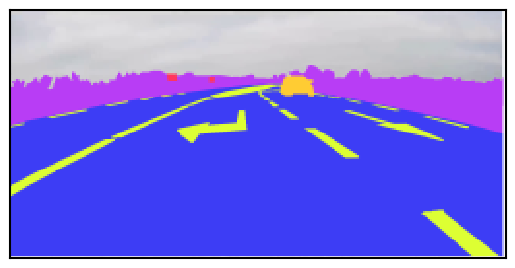

In [2]:
standart_image_path = './data/images/0.png'
segmented_image_path = './data/masks/0.png'
standart_image = cv2.cvtColor(cv2.imread(standart_image_path), cv2.COLOR_BGR2RGB)
segmented_image = cv2.cvtColor(cv2.imread(segmented_image_path), cv2.COLOR_BGR2RGB)
standart_image = cv2.resize(standart_image, (256, 128), interpolation = cv2.INTER_AREA)
segmented_image = cv2.resize(segmented_image, (256, 128), interpolation = cv2.INTER_AREA)
isns.imgplot(standart_image)
isns.imgplot(segmented_image)


In [3]:
id_color = {
    0: [255, 0, 0],
    1: [0, 255, 0],
    2: [0, 0, 255],
    3: [100, 0, 200],
    4: [255, 0, 255],
    5: [0, 255, 255],
    6: [100, 200, 0],
    7: [200, 100, 0],
    8: [0, 100, 200],
    9: [0, 200, 100],
    10: [200, 0, 100],
    11: [255, 255, 0],
    12: [100, 200, 100],
    13: [200, 100, 100],
    14: [200, 100, 200],
    15: [200, 200, 100],
}

# One pixel

In [4]:
def getOnePosColorPixelMass(img):
    m = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            m.append([i, j, *img[i, j]])
    return np.array(m)


def onePosColorPixelMassToImg(data):
    m = np.zeros([data[:, 0].max()+1, data[:, 1].max()+1, 3])
    for i in data:
        m[i[0], i[1]] = i[2:]
    # print(i, j)
    return np.array(m, dtype=np.uint8)


def onePosColorPixelMassToImgMasked(data, mask):
    m = np.zeros([data[:, 0].max()+1, data[:, 1].max()+1, 3])
    k = 0
    for i in data:
        m[i[0], i[1]] = mask[k]
        k += 1
    # print(i, j)
    return np.array(m, dtype=np.uint8)

In [5]:
one_pixel_test_data = getOnePosColorPixelMass(standart_image)

# one_pixel_test_data = getOnePosColorPixelMass(standart_image)

<Axes: >

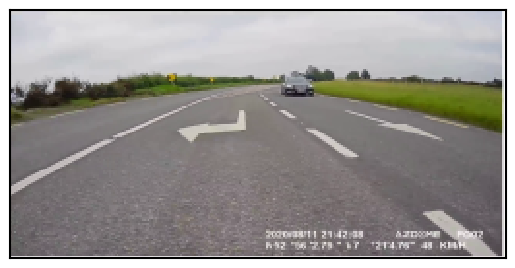

In [6]:
isns.imgplot(onePosColorPixelMassToImg(one_pixel_test_data).astype(int))

In [7]:
mean_vec = one_pixel_test_data.mean(axis=0)
med_vec = np.median(one_pixel_test_data, axis=0)
k_mean = []
k_med = []
for i in one_pixel_test_data:
    k_mean.append(minkowski(mean_vec, i))
    k_med.append(minkowski(med_vec, i))
print('mean:', np.std(k_mean), np.mean(k_mean), np.median(k_mean))
print('med:', np.std(k_med), np.mean(k_med), np.median(k_med))

mean: 44.50715824853696 109.46870837595313 114.11702316009286
med: 54.020748175873045 109.68237894547168 108.17347169539867


In [8]:
mean_vec = one_pixel_test_data.mean(axis=0)
med_vec = np.median(one_pixel_test_data, axis=0)
k_mean = []
k_med = []
for i in one_pixel_test_data:
    k_mean.append(euclidean(mean_vec, i))
    k_med.append(euclidean(med_vec, i))
print('mean:', np.std(k_mean), np.mean(k_mean), np.median(k_mean))
print('med:', np.std(k_med), np.mean(k_med), np.median(k_med))

mean: 44.50715824853696 109.46870837595313 114.11702316009286
med: 54.020748175873045 109.68237894547168 108.17347169539867


В общем два выше написанных фрагмента - полная туфта. Я определил значение расстояния при котором почти все пиксели сольются в один кластер

In [9]:
nn_models = []
for n_clusters in tqdm(range(2, 15, 2)):
    nn_models.append(KMeans(n_clusters=n_clusters).fit(one_pixel_test_data))

100%|██████████| 7/7 [00:00<00:00,  9.80it/s]


In [10]:
dbscan_models = []
for eps in tqdm(range(2, 10, 2)):
    dbscan_models.append([DBSCAN(eps=eps, min_samples=n_el).fit(one_pixel_test_data) for n_el in range(5, 15, 2)])

100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Остаток от деление на 1000 объекта - его номер
Целая часть - класс

* Машинки - 33001 к примеру

smp - segmentation models pytorch

progress_bar

На матрицах можно юзать мулти процессинг

Есть изображения где у нас нет нужных классов

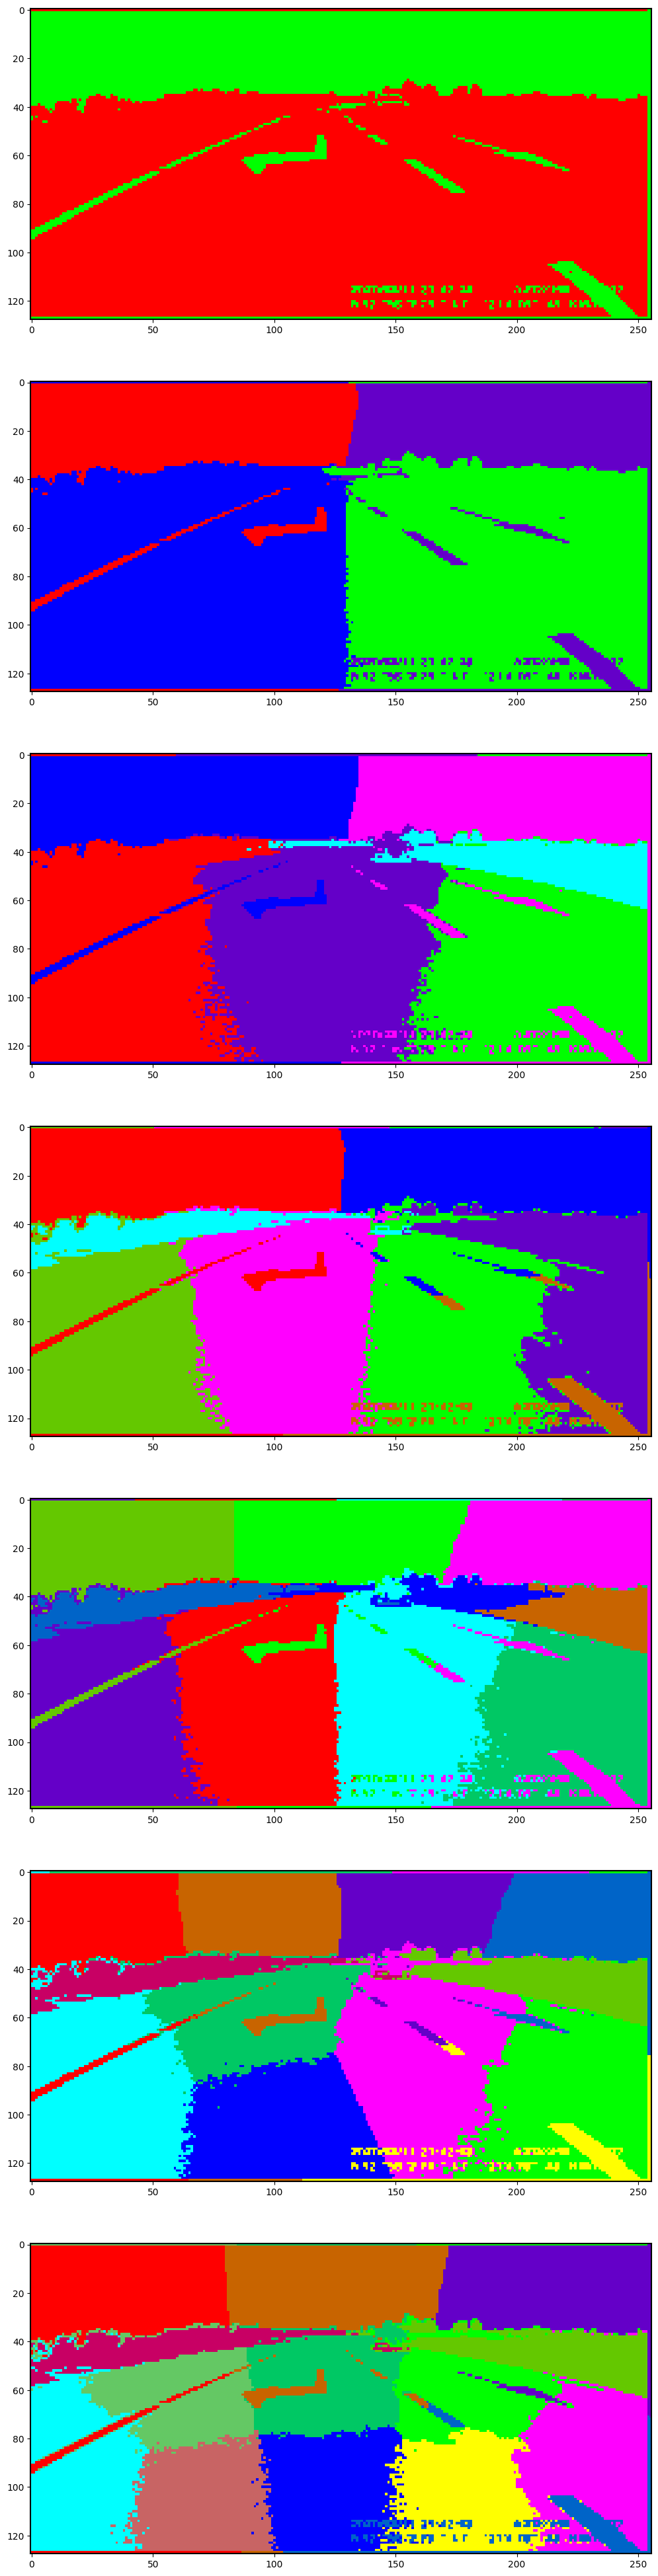

In [11]:
fig, axes = plt.subplots(len(nn_models), 1, figsize=(100, 50))
for i in range(len(nn_models)):
    mask = [id_color[i] for i in nn_models[i].labels_]
    axes[i].imshow(onePosColorPixelMassToImgMasked(one_pixel_test_data, mask))

<Axes: >

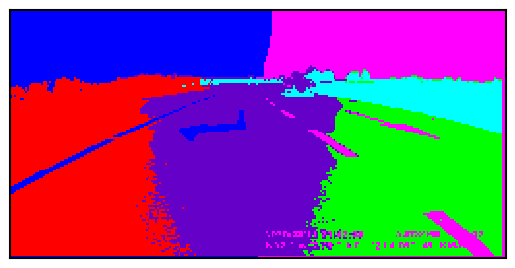

In [12]:
mask = [id_color[i] for i in nn_models[2].labels_]
isns.imgplot(onePosColorPixelMassToImgMasked(one_pixel_test_data, mask))

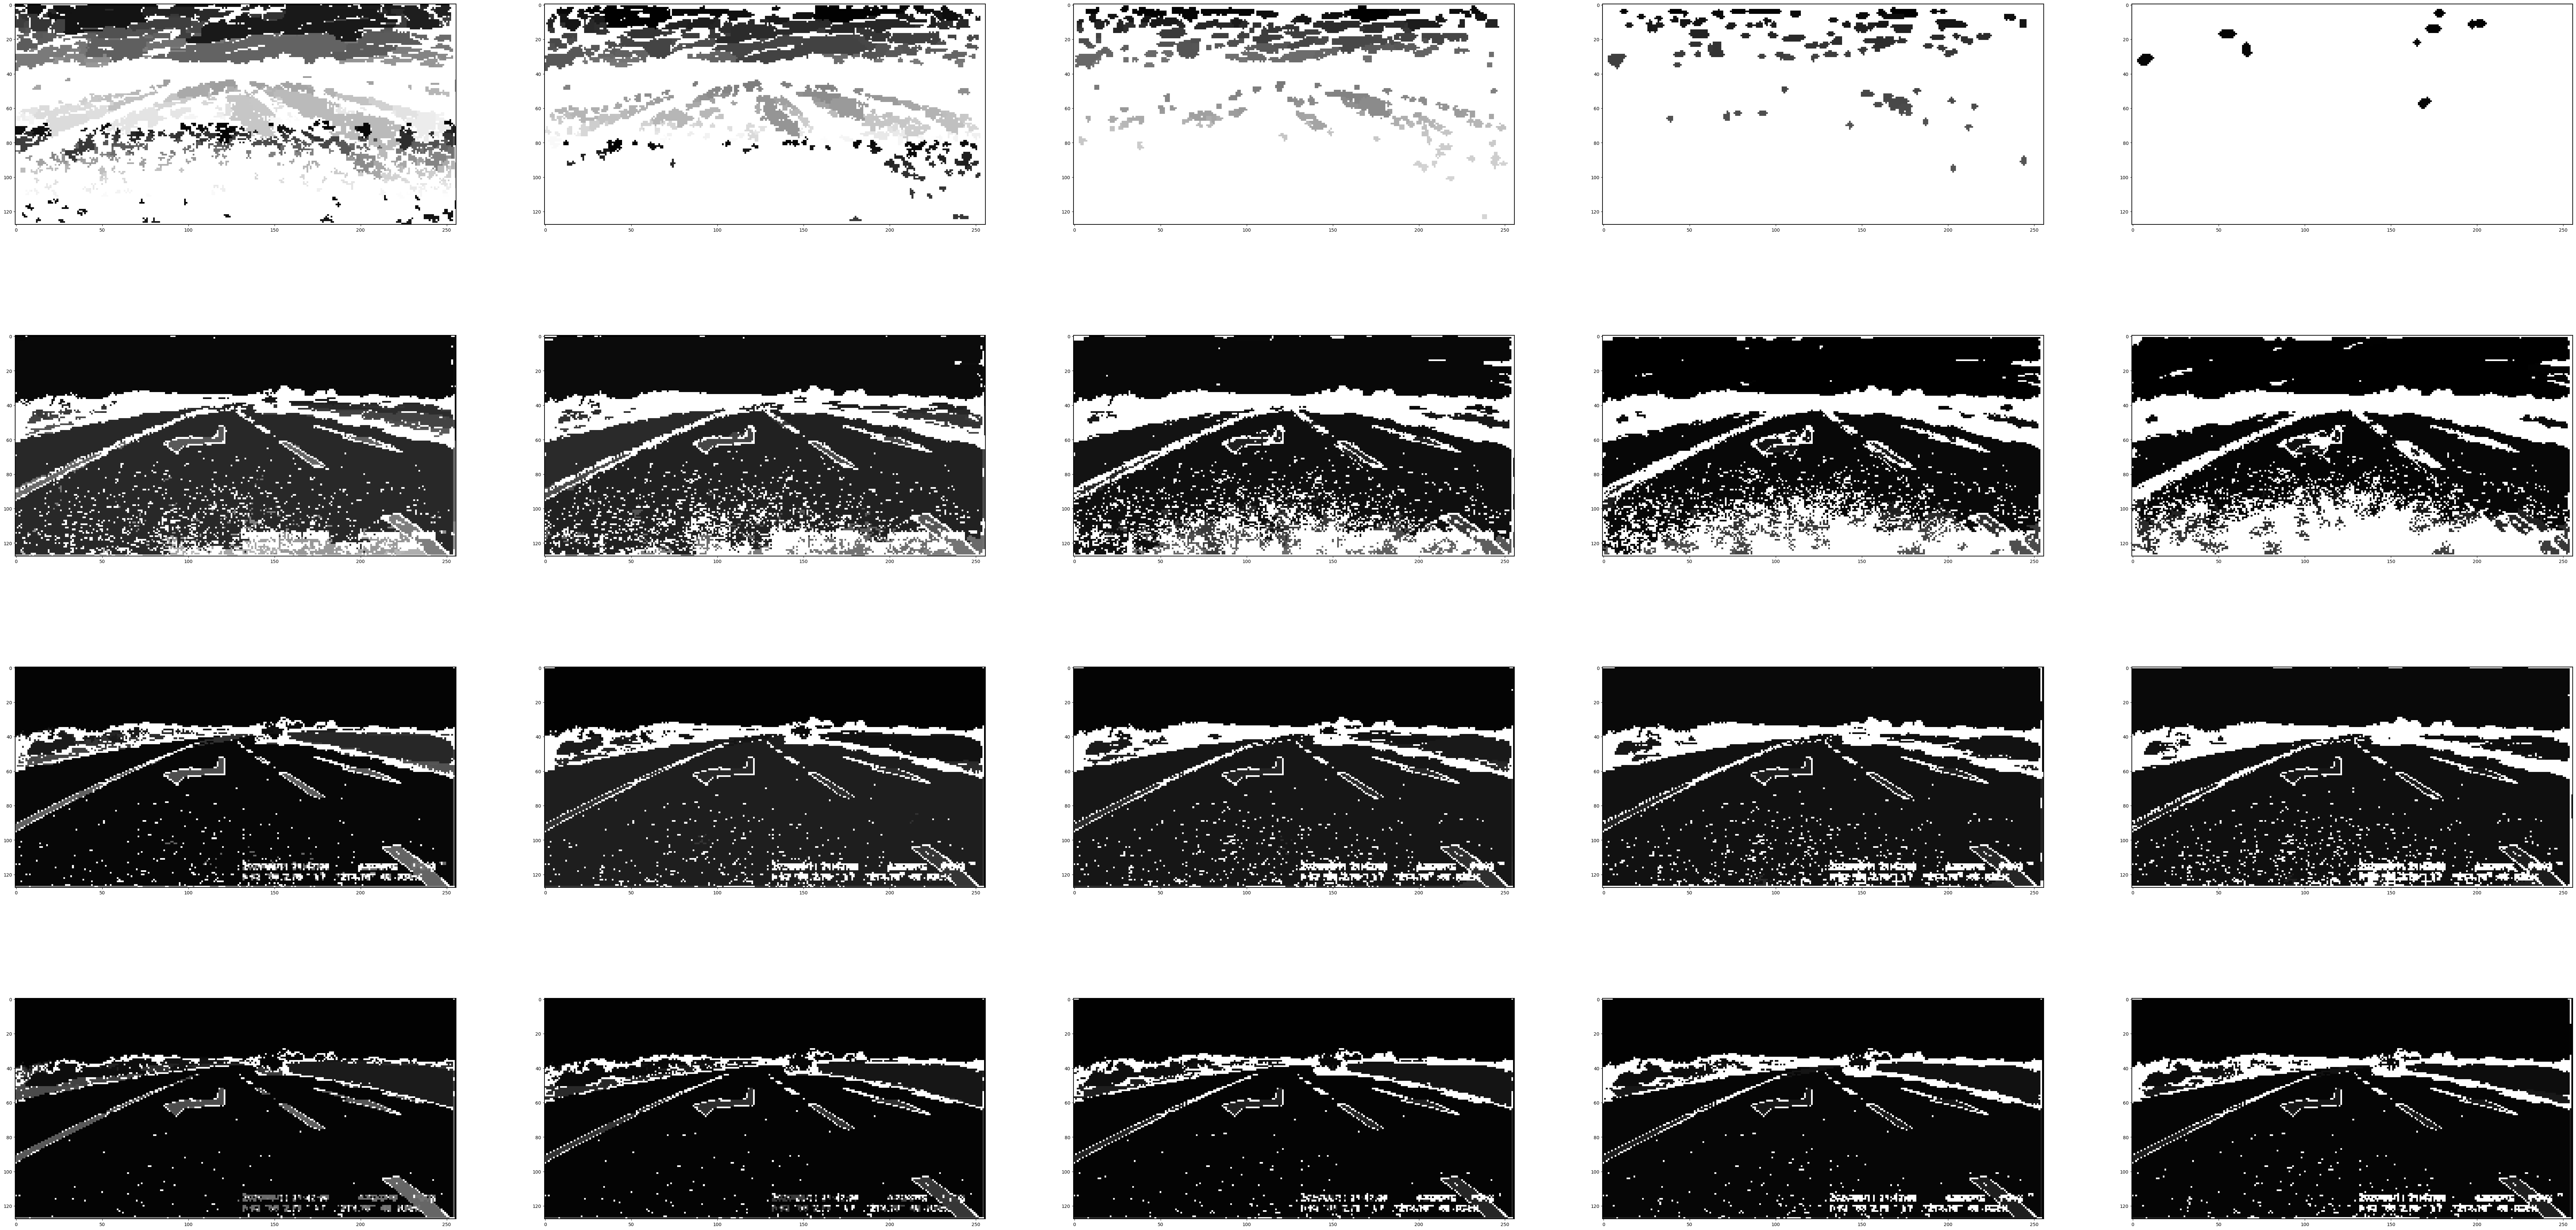

In [13]:
fig, axes = plt.subplots(len(dbscan_models), len(dbscan_models[0]), figsize=(100, 50))
for i in range(len(dbscan_models)):
    for j in range(len(dbscan_models[0])):
        mask = [i for i in dbscan_models[i][j].labels_]
        axes[i, j].imshow(onePosColorPixelMassToImgMasked(one_pixel_test_data, mask))

# Ambit

<Axes: >

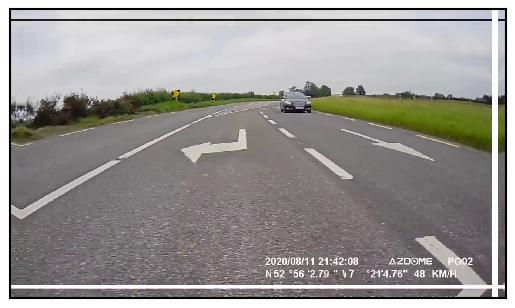

In [23]:
border_size = 30
border = cv2.copyMakeBorder(
    standart_image,
    top=border_size,
    bottom=border_size,
    left=border_size,
    right=border_size,
    borderType=cv2.BORDER_REFLECT,
)
isns.imgplot(border)

In [24]:
def vectorizeAmbitPixel(img, ambit_size=5):
    m = []
    for i in range(ambit_size, img.shape[0]- ambit_size):
        for j in range(ambit_size, img.shape[1] - ambit_size):
            t = img[(i - ambit_size):(i + ambit_size), (j - ambit_size):(j + ambit_size), :]
            m.append(t.reshape(1, -1).tolist())
    return np.array(m)[:, 0, :]
    



In [25]:
d = KMeans(n_clusters=100).fit(vectorizeAmbitPixel(border), border_size)

In [26]:
m = np.zeros(standart_image.shape)
for i in range(standart_image.shape[0]):
    for j in range(standart_image.shape[1]):
        m[i, j] = d.labels_[i * standart_image.shape[0] + j]


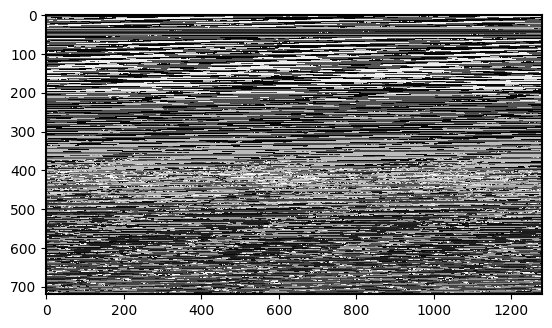

In [27]:
# isns.imgplot(m)
plt.imshow(m/m.max())